# <center> Predicting AFL Match Results with XGBoost </center>
<img src="afl_logo.png"/>

## <center>Beating the bookies for fun and profit!</center>

## What is AFL?

The AFL is the Australian Rules Football League. You work/study in Melbourne so you'll have a hard time avoiding it.

## What is XGBoost?
XGBoost is a machine learning (ML) package for creating supervised classification models for use with tabular data. The method used by XGBoost is a gradient boosted random forest... I will describe this at a high level, but there is a lot more information available on the XGBoost website (as well as all over the internet). At the moment, XGBoost is among the most popular methods used in data science because it allows you to create surprisingly accurate models with minimal effort (as you'll see here...). If you're familiar with Kaggle, you will find that for contests with tabular data, XGBoost is very commonly found among the top performers. 

### Random forest??

A random forest is a particular type of ML method that uses an ensemble of "decision trees" to classify some object based on its various "features". An individual decision tree is essentially a flow chart that one might follow to make a decision, the basic structure looks like this:
<img src="decision_tree1.png"/>

and here is an example with actual decisions:
<img src="decision_tree2.jpg"/>

Individual decision trees can be complex, but will have limitations as any individual tree will consider certain features of your data more important than others. While this is likely justified, there will be exceptions and these will be misclassified. 

This is where a "random forest" comes in. A random forest is simply an ensemble of many individual decision trees that each have slightly different structures. When a random forest is applied to a given set of observations, it will apply each individual decision tree and then determine the ultimate classification from the most frequent classification among each individual classification. 

### Gradient Boosting?

The other aspect of XGBoost is gradient boosting. In a nutshell, XGBoost first creates one decision tree to classify the training data then applies this tree and checks how many items were misclassified and quantifies this using a "loss function". Next, a second tree is added that attempts to account for the failures of the previous tree. In this sense the new tree is fit to the residual of the previous model, and the new model is the linear combination of the first and second trees. This process is repeated until a level of convergence is reached. It turns out that the residual in each case is related to the derivative of the loss function, and this is the origin of the term "gradient boosting".

This explanation obviously leaves a lot to be desired, so if you want to know more just Google it. XGBoost In order to use XGBoost effectively, you don't actually need to know any of this. The purpose of this notebook is simply to show you how to get started with preparing your data, creating an XGBoost model, tuning hyper-parameters, and doing some basic interpretation of the results. 

## The Data:

(_The data for this project was scraped from an AFL stats website using the package Beautiful Soup. I was going to give a quick tutorial on web scraping HTML tables, but while writing and testing my scraping script I believe that I was identified as a malicious entity and subsequently blocked. I was able to get around this once and finish scraping the data that I wanted and now that its collected I'm going to leave it alone..._)

I've acquired match data for all AFL matches for seasons 2008-2019, and focused on only extacting features that would be available before the match took place as these will be the features that can be used to predict the winner of a future match. These features include things like home and team win percentages, venue, game time/date, home/away team average goals per game, among others. Data for each year have been saved in a numpy .npz file, but a pandas dataframe would work just as well (maybe better).

### Data Preparation

The majority of your time when working on a ML project will be spent preparing your data and getting it into a format appropriate for the particular ML method you'd like to use. In this case, each match will be represented by a vector or numbers representing the various "features" we've extracted and a result that we are trying to predict. We must first come up with a standard format for the data.

For the results, we will be predicting whether or not the home team has won or lost the match with a win represented by a 1 and a loss represented by a 0 (I'm going to ignore draws because these are pretty rare so failing to predict if a match is a draw is not going to hurt our accuracy much...). Thus, the results will simply be a long list of 0's and 1's with a length equal to the number of matches that have been extracted. 

For the features, each match will be represented by 21 values:

1. Round Number
2. Venue
3. Home Team
4. Away Team
5. Time
6. Average Player Age (home team)
7. Total Games (home team)
8. Win Percentage (home team)
9. Total Goals (home team)
10. Average Goals per Game (home team)
11. Coach Age (home team)
12. Total Games (home team coach)
13. Win Percentage (home team coach)
14. Average Player Age (away team)
15. Total Games (away team)
16. Win Percentage (away team)
17. Total Goals (away team)
18. Average Goals per Game (away team)
19. Coach Age (away team)
20. Total Games (away team coach)
21. Win Percentage (away team coach)

The venue and team names are obviously represented by strings, so we first have to collect all possible values for these and assign them a number arbitrarily. Then for each game features, the venue and team names are replaced by this numerical value (try one hot encoding?). Although there is some ordering here (i.e. the home team stats are listed followed by the away team stats), but the order here actually doesn't matter at all. The order could be entirely randomised and, so long as the same ordering is used for every match, the results should be identical. XGBoost doesn't actually know what any of these things are or what their actual significance is, it just identifies  abstract mathematical patterns between them to classify each match.

### OK, lets load the data and have a look.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataprep import get_hash_tables, load_year

seasons = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
# get_hash_tables loads all the team and venue names for all seasons and
# constructs two hash tables with a unique, numerical values for each
team_hash_table,venue_hash_table = get_hash_tables(seasons)

for key in team_hash_table.keys():
    print(key,team_hash_table[key])

Carlton 0
Port Adelaide 1
Collingwood 2
West Coast 3
St Kilda 4
Western Bulldogs 5
Hawthorn 6
North Melbourne 7
Brisbane Lions 8
Adelaide 9
Fremantle 10
Sydney 11
Geelong 12
Richmond 13
Essendon 14
Melbourne 15
Gold Coast 16
Greater Western Sydney 17


In [3]:
# Now load the data for each game and pass it through the function "load_year"
# which formats it into the 21 length vector described above
X,Y = load_year('./2008_data.npz',team_hash_table,venue_hash_table)
for yr in ['09','10','11','12','13','14','15','16','17','18','19']:
    x,y = load_year(f'./20{yr}_data.npz',team_hash_table,venue_hash_table)
    X = np.vstack((X,x))
    Y = np.concatenate((Y,y))
    
print('Features:',X[0])
print('Results:',Y[0])

Features: [1.0000e+00 0.0000e+00 0.0000e+00 1.3000e+01 6.1000e+02 8.5600e+03
 1.4170e+03 3.2390e+01 1.0770e+03 7.6000e-01 1.3393e+04 7.0000e+00
 0.0000e+00 9.0830e+03 1.9820e+03 3.9350e+01 1.8040e+03 9.1000e-01
 1.7983e+04 2.1500e+02 4.9070e+01]
Results: 0


We can see based on the 3rd and 4th values that this match was between home team Carlton (team 0) and away team Richmond (team 13) and that Carlton lost (result = 0, home team lost).

In [4]:
# Here we see that X is a 2077x21 array, so we have data for 2077 matches for training and testing our model
print(X.shape)

(2077, 21)


There is probably more feature engineering I can do here that could ultimately result in better model accuracy, but lets just move forward with these "raw" features and see how well we can do. The next step is to split the data:

### Train-Test Splitting:

It's important to split your data into a training and testing set as XGBoost can often come up with a model that can predict the data its trained on with very high accuracy, but this is not reflective of how accurate the model will be when presented with new data. To test the _true_ accuracy of the model, you must provide some data that it hasn't seen yet and see how well it can predict this. For even more rigorous modelling you can do something called K-fold cross-validation, but I'll leave that to you to explore.

Often times you will see tutorials using train_test_split (or similar) from sklearn.model_selection for doing this. This will randomly split your entire dataset into two groups. In this case, games come in groups of seasons, so we want to avoid a situation where certain permutations are excluded from the training set (e.g. no Carlton matches, no round 1 matches, etc), so we are simply going to use seasons from 2008 to 2017 as our training set then reserve 2018 and 2019 seasons for testing our model:



In [5]:
"""
This is how train test split works in sklearn just FYI

from sklearn.model_selection import train_test_split

# Here the kwarg "test_size" tells the sklearn what fraction of the data
# to reserve for testing the model. In this case 30% of the data is reserved.
# Note that this splitting is done randomly, so if you run this twice you can
# get two different training sets that will ultimately result in two slightly
# different models. If you want to return the same split every time, which
# may be useful for testing, train_test_split has another kwarg "random_state"
# that determines the initial seed and can be set to some arbitrary number.

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)
"""
X,Y = load_year('./2008_data.npz',team_hash_table,venue_hash_table)
for yr in ['09','10','11','12','13','14','15','16','17']:
    x,y = load_year(f'./20{yr}_data.npz',team_hash_table,venue_hash_table)
    X = np.vstack((X,x))
    Y = np.concatenate((Y,y))

X_train,y_train = X,Y
X_test1,y_test1 = load_year('./2018_data.npz',team_hash_table,venue_hash_table)
X_test2,y_test2 = load_year('./2019_data.npz',team_hash_table,venue_hash_table)

print(f'Training set size: {len(y_train)}')
print(f'Test set 1 size: {len(y_test1)}')
print(f'Test set 2 size: {len(y_test2)}')

Training set size: 1723
Test set 1 size: 177
Test set 2 size: 177


In [22]:
feature_labels = [
    'round num',
    'venue',
    'home team',
    'away team',
    'time',
    'avg age(home)',
    'games (home)',
    'win perc(home)',
    'goals (home)',
    'avg goals (home)',
    'coach age (home)',
    'coach games (home)',
    'coach win perc (home)',
    'avg age (away)',
    'games (away)',
    'win perc (away)',
    'goals (away)',
    'avg goals (away)',
    'coach age (away)',
    'coach games (away)',
    'coach win perc (away)'
]

X_train = pd.DataFrame(data=X_train,columns=feature_labels)
X_test1 = pd.DataFrame(data=X_test1,columns=feature_labels)
X_test2 = pd.DataFrame(data=X_test2,columns=feature_labels)

## Initialising Hyper-Parameters:

Now we need to set up the hyperparamters that XGBoost will use for building the model. The model will be somewhat sensitive to these parameters, so later we will see how to tune these to get the best performance. For now we will just put in some values that are in the ranges typical for XGBoost models (you can Google this):

In [23]:
# Here the "objective" is set to "binary:logistic" which just means we are
# doing binary classification since the result is either 0 or 1, and that we
# are doing this by logistic regression. Ultimately this is important and
# the selection will depend on the exact classification task you are performing.
# I will also leave this to you to look into further if you want to use XGBoost
# for your own problems.

xg_par = {
    'objective':'binary:logistic',
    'colsample_bytree':.1,
    'subsample':.2,
    'learning_rate':.001,
    'gamma':12,
    'max_depth':2,
    'reg_alpha':0.3,
    'eval_metric':'rmse',
}

### Training the Model:
We're going to use the sklearn style XGBoost for this

In [24]:
from xgboost.sklearn import XGBClassifier,XGBRegressor

# Set up the model using the parameters we specified:
xg_mod = XGBClassifier(**xg_par,)

# Train the model:
xg_mod.fit(tst,y_train)

# Use the trained model to predict the test set results:
pred1 = xg_mod.predict(X_test1)
print(pred1)
pred2 = xg_mod.predict(X_test2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1]


Now we just need to compare this with the test set's actual results to evaluate the accuracy of this model:

In [25]:
from sklearn.metrics import balanced_accuracy_score as acc

print(f'2018 accuracy: {acc(y_test1,pred1)}')
print(f'2019 accuracy: {acc(y_test2,pred2)}')

2018 accuracy: 0.5664961636828645
2019 accuracy: 0.5519607843137255


Considering this is a binary classification, flipping a coin should yield 0.5, so this clearly hasn't been worth the trouble at this point (though its likely already a significant improvement on my footy tipping efforts which I suspect would have been improved by flipping a coin...)

How can we do better? The are a few things that we could try:

1. We can try to get more features that may be better predictors of wether or not the home team would win. These can either be completely new features that weren't included here, or some combination of the features we already used to create a new feature. This could be time consuming...

2. Try a different type of model (e.g. neural network). Typically XGBoost is going to be as good or better than any other type of model for this type of problem (though there are exceptions of course). Really, the best bet is to get new features, because the power of ML is in the data: if you can identify the key features that are most predictive for your problem you will get the best results.

3. We can "tune" the hyperparamters and determine the exact values that provide the most accurate model. There is a lot of info on how to do this fairly simply, so it really doesn't cost you much to try this first. If you don't achieve the improvement you wanted here, you can then go back and try to get new features. We'll try this for now.

### Hyperparameter Tuning:

In the model we created above we simply semi-randomly selected some input hyperparameters for XGBoost based on the typical values you usually see online. There is likely a set of hyperparameters that will do a better job, though, so the process of hyperparameter tuning is a way of determining which are the best parameters. There are different ways to do this, including some built in methods in sklearn like grid search and random search. In both cases, you supply a discrete set of parameter values to test. Grid search is a brute force method that tests all possible combinations while the random search just takes a random sampling. The former takes much longer but covers all possibilities, we'll try a grid search here. I'm not using a lot of parameter options just to make it run faster.

In [26]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.02,0.05], #so called `eta` value
              'max_depth': [8,10],
              'min_child_weight': [1,10],
              'silent': [1],
              'subsample': [0.5,1.],
              'colsample_bytree': [0.7],
              'n_estimators': [150],
              'seed': [1337]}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
xg_tuned = XGBClassifier()
grid = GridSearchCV(xg_tuned, 
                        param_grid=parameters,
                        n_jobs=4,
                        cv=skf.split(X_train,y_train), 
                        scoring='roc_auc',
                        verbose=3, refit=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   49.5s finished


[11:41:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=<generator object _BaseKFold.split at 0x1159ccd50>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learni

In [27]:
best = grid.best_params_
print(best)
xg_tuned = XGBClassifier(**best)
xg_tuned.fit(X_train,y_train)
pred1 = xg_tuned.predict(X_test1)
pred2 = xg_tuned.predict(X_test2)
print(f'2018 accuracy = {acc(y_test1,pred1)}')
print(f'2019 accuracy = {acc(y_test2,pred2)}')

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 150, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 1.0}
[11:42:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


2018 accuracy = 0.7207161125319693
2019 accuracy = 0.634313725490196


Wow, ok we're now doing 8-16% better just by choosing better hyperparameters with a fairly narrow grid search!
We can do something a bit more rigorous using method of hyperparameter tuning that is gaining in popularity employing Bayesian optimization. One package to do this is hyperopt, which can be installed with pip. This differs from grid/random searches because you provide a continuous value range for each parameter you want to tune rather than discrete values. This avoids the situation where you've done a grid search but failed to include the optimal combination:

In [28]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


parameter_space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
                  'gamma': hp.uniform ('gamma', 0,9),
                  'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
                  'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                  'learning_rate' : hp.uniform('learning_rate',0.02,0.1),
                  'subsample' : hp.uniform('subsample',0.5,1.),
                  'n_estimators': 1000
}

def hyperparameter_tuning(space):
    model = XGBClassifier(
        objective = 'binary:logistic',
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        colsample_bytree = space['colsample_bytree'],
        min_child_weight = space['min_child_weight'],
        learning_rate = space['learning_rate'],
        n_estimators = int(space['n_estimators']),
        seed = 1337
    )
    evals = [(X_test1,y_test1), (X_test2,y_test2)]
    
    model.fit(X_train,y_train,eval_metric='rmse',eval_set=evals,early_stopping_rounds=10)
    pred1 = model.predict(X_test1)
    pred2 = model.predict(X_test2)
    accuracy = np.mean([acc(y_test1, pred1),acc(y_test2, pred2)])
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=parameter_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

[0]	validation_0-rmse:0.49536	validation_1-rmse:0.49695

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.

[1]	validation_0-rmse:0.49300	validation_1-rmse:0.49511

[2]	validation_0-rmse:0.48917	validation_1-rmse:0.49258

[3]	validation_0-rmse:0.48555	validation_1-rmse:0.49025

[4]	validation_0-rmse:0.48156	validation_1-rmse:0.48797

[5]	validation_0-rmse:0.47809	validation_1-rmse:0.48516

[6]	validation_0-rmse:0.47624	validation_1-rmse:0.48241

[7]	validation_0-rmse:0.47490	validation_1-rmse:0.48024

[8]	validation_0-rmse:0.47221	validation_1-rmse:0.47876

[9]	validation_0-rmse:0.47049	validation_1-rmse:0.47783

[10]	validation_0-rmse:0.46832	validation_1-rmse:0.47669

[11]	validation_0-rmse:0.46698	validation_1-rmse:0.47631

[12]	validation_0-rmse:0.46583	validation_1-rmse:0.47492

[13]	validation_0-rmse:0.46469	validation_1-rmse:0.47333

[14]	validation_0-rmse:0.46240	valida

[57]	validation_0-rmse:0.45089	validation_1-rmse:0.46670                          

[58]	validation_0-rmse:0.45101	validation_1-rmse:0.46659                          

[59]	validation_0-rmse:0.45083	validation_1-rmse:0.46661                          

[60]	validation_0-rmse:0.45068	validation_1-rmse:0.46636                          

[61]	validation_0-rmse:0.45024	validation_1-rmse:0.46617                          

[62]	validation_0-rmse:0.45036	validation_1-rmse:0.46631                          

[63]	validation_0-rmse:0.45011	validation_1-rmse:0.46610                          

[64]	validation_0-rmse:0.45010	validation_1-rmse:0.46616                          

[65]	validation_0-rmse:0.45021	validation_1-rmse:0.46611                          

[66]	validation_0-rmse:0.45004	validation_1-rmse:0.46599                          

[67]	validation_0-rmse:0.45007	validation_1-rmse:0.46588                          

[68]	validation_0-rmse:0.45004	validation_1-rmse:0.46582                    

[9]	validation_0-rmse:0.45602	validation_1-rmse:0.46882                           

[10]	validation_0-rmse:0.45463	validation_1-rmse:0.46779                          

[11]	validation_0-rmse:0.45253	validation_1-rmse:0.46779                          

[12]	validation_0-rmse:0.44998	validation_1-rmse:0.46602                          

[13]	validation_0-rmse:0.44943	validation_1-rmse:0.46585                          

[14]	validation_0-rmse:0.44726	validation_1-rmse:0.46537                          

[15]	validation_0-rmse:0.44722	validation_1-rmse:0.46504                          

[16]	validation_0-rmse:0.44581	validation_1-rmse:0.46386                          

[17]	validation_0-rmse:0.44515	validation_1-rmse:0.46343                          

[18]	validation_0-rmse:0.44448	validation_1-rmse:0.46302                          

[19]	validation_0-rmse:0.44448	validation_1-rmse:0.46263                          

[20]	validation_0-rmse:0.44409	validation_1-rmse:0.46291                    

[10]	validation_0-rmse:0.47189	validation_1-rmse:0.47613                          

[11]	validation_0-rmse:0.47079	validation_1-rmse:0.47479                          

[12]	validation_0-rmse:0.46919	validation_1-rmse:0.47333                          

[13]	validation_0-rmse:0.46814	validation_1-rmse:0.47271                          

[14]	validation_0-rmse:0.46660	validation_1-rmse:0.47189                          

[15]	validation_0-rmse:0.46552	validation_1-rmse:0.47084                          

[16]	validation_0-rmse:0.46401	validation_1-rmse:0.47072                          

[17]	validation_0-rmse:0.46254	validation_1-rmse:0.47006                          

[18]	validation_0-rmse:0.46175	validation_1-rmse:0.46950                          

[19]	validation_0-rmse:0.46135	validation_1-rmse:0.46961                          

[20]	validation_0-rmse:0.46072	validation_1-rmse:0.46937                          

[21]	validation_0-rmse:0.46019	validation_1-rmse:0.46819                    

[62]	validation_0-rmse:0.45612	validation_1-rmse:0.46289                          

[63]	validation_0-rmse:0.45629	validation_1-rmse:0.46268                          

[64]	validation_0-rmse:0.45637	validation_1-rmse:0.46292                          

[65]	validation_0-rmse:0.45651	validation_1-rmse:0.46259                          

[66]	validation_0-rmse:0.45614	validation_1-rmse:0.46258                          

[67]	validation_0-rmse:0.45632	validation_1-rmse:0.46247                          

[68]	validation_0-rmse:0.45636	validation_1-rmse:0.46215                          

[69]	validation_0-rmse:0.45647	validation_1-rmse:0.46213                          

[70]	validation_0-rmse:0.45634	validation_1-rmse:0.46275                          

[71]	validation_0-rmse:0.45594	validation_1-rmse:0.46289                          

[72]	validation_0-rmse:0.45561	validation_1-rmse:0.46271                          

[73]	validation_0-rmse:0.45536	validation_1-rmse:0.46265                    

[1]	validation_0-rmse:0.49540	validation_1-rmse:0.49516                           

[2]	validation_0-rmse:0.49184	validation_1-rmse:0.49380                           

[3]	validation_0-rmse:0.48892	validation_1-rmse:0.49178                           

[4]	validation_0-rmse:0.48550	validation_1-rmse:0.48973                           

[5]	validation_0-rmse:0.48434	validation_1-rmse:0.48747                           

[6]	validation_0-rmse:0.48205	validation_1-rmse:0.48538                           

[7]	validation_0-rmse:0.47948	validation_1-rmse:0.48349                           

[8]	validation_0-rmse:0.47688	validation_1-rmse:0.48128                           

[9]	validation_0-rmse:0.47468	validation_1-rmse:0.47975                           

[10]	validation_0-rmse:0.47182	validation_1-rmse:0.47919                          

[11]	validation_0-rmse:0.46959	validation_1-rmse:0.47822                          

[12]	validation_0-rmse:0.46836	validation_1-rmse:0.47496                    

[40]	validation_0-rmse:0.45497	validation_1-rmse:0.47088                          

[41]	validation_0-rmse:0.45486	validation_1-rmse:0.47057                          

[42]	validation_0-rmse:0.45483	validation_1-rmse:0.47048                          

[43]	validation_0-rmse:0.45494	validation_1-rmse:0.47005                          

[44]	validation_0-rmse:0.45506	validation_1-rmse:0.47027                          

[45]	validation_0-rmse:0.45513	validation_1-rmse:0.47014                          

[46]	validation_0-rmse:0.45534	validation_1-rmse:0.47012                          

[47]	validation_0-rmse:0.45624	validation_1-rmse:0.47016                          

[48]	validation_0-rmse:0.45626	validation_1-rmse:0.47015                          

[49]	validation_0-rmse:0.45625	validation_1-rmse:0.47007                          

[50]	validation_0-rmse:0.45554	validation_1-rmse:0.46949                          

[51]	validation_0-rmse:0.45510	validation_1-rmse:0.46977                    

[19]	validation_0-rmse:0.46094	validation_1-rmse:0.47304                           

[20]	validation_0-rmse:0.46027	validation_1-rmse:0.47280                           

[21]	validation_0-rmse:0.45943	validation_1-rmse:0.47170                           

[22]	validation_0-rmse:0.45861	validation_1-rmse:0.47118                           

[23]	validation_0-rmse:0.45716	validation_1-rmse:0.47056                           

[24]	validation_0-rmse:0.45642	validation_1-rmse:0.47042                           

[25]	validation_0-rmse:0.45571	validation_1-rmse:0.47016                           

[26]	validation_0-rmse:0.45474	validation_1-rmse:0.46997                           

[27]	validation_0-rmse:0.45394	validation_1-rmse:0.46977                           

[28]	validation_0-rmse:0.45355	validation_1-rmse:0.46965                           

[29]	validation_0-rmse:0.45294	validation_1-rmse:0.46925                           

[30]	validation_0-rmse:0.45184	validation_1-rmse:0.46847         

[1]	validation_0-rmse:0.49458	validation_1-rmse:0.49162                            

[2]	validation_0-rmse:0.48930	validation_1-rmse:0.48850                            

[3]	validation_0-rmse:0.48560	validation_1-rmse:0.48632                            

[4]	validation_0-rmse:0.48153	validation_1-rmse:0.48291                            

[5]	validation_0-rmse:0.47902	validation_1-rmse:0.47957                            

[6]	validation_0-rmse:0.47749	validation_1-rmse:0.47844                            

[7]	validation_0-rmse:0.47743	validation_1-rmse:0.47831                            

[8]	validation_0-rmse:0.47396	validation_1-rmse:0.47539                            

[9]	validation_0-rmse:0.47282	validation_1-rmse:0.47446                            

[10]	validation_0-rmse:0.47104	validation_1-rmse:0.47263                           

[11]	validation_0-rmse:0.47018	validation_1-rmse:0.47087                           

[12]	validation_0-rmse:0.47112	validation_1-rmse:0.47057         

[15]	validation_0-rmse:0.47108	validation_1-rmse:0.47922                           

[16]	validation_0-rmse:0.47002	validation_1-rmse:0.47841                           

[17]	validation_0-rmse:0.46842	validation_1-rmse:0.47757                           

[18]	validation_0-rmse:0.46731	validation_1-rmse:0.47709                           

[19]	validation_0-rmse:0.46598	validation_1-rmse:0.47675                           

[20]	validation_0-rmse:0.46497	validation_1-rmse:0.47619                           

[21]	validation_0-rmse:0.46363	validation_1-rmse:0.47525                           

[22]	validation_0-rmse:0.46266	validation_1-rmse:0.47474                           

[23]	validation_0-rmse:0.46203	validation_1-rmse:0.47409                           

[24]	validation_0-rmse:0.46131	validation_1-rmse:0.47390                           

[25]	validation_0-rmse:0.46034	validation_1-rmse:0.47364                           

[26]	validation_0-rmse:0.45946	validation_1-rmse:0.47321         

[35]	validation_0-rmse:0.44631	validation_1-rmse:0.46914                           

[36]	validation_0-rmse:0.44636	validation_1-rmse:0.46943                           

[37]	validation_0-rmse:0.44579	validation_1-rmse:0.46934                           

[38]	validation_0-rmse:0.44449	validation_1-rmse:0.46887                           

[39]	validation_0-rmse:0.44489	validation_1-rmse:0.46915                           

[40]	validation_0-rmse:0.44522	validation_1-rmse:0.46929                           

[41]	validation_0-rmse:0.44440	validation_1-rmse:0.46892                           

[42]	validation_0-rmse:0.44433	validation_1-rmse:0.46865                           

[43]	validation_0-rmse:0.44344	validation_1-rmse:0.46815                           

[44]	validation_0-rmse:0.44310	validation_1-rmse:0.46837                           

[45]	validation_0-rmse:0.44277	validation_1-rmse:0.46894                           

[46]	validation_0-rmse:0.44260	validation_1-rmse:0.46932         

[73]	validation_0-rmse:0.44396	validation_1-rmse:0.46338                           

[74]	validation_0-rmse:0.44371	validation_1-rmse:0.46388                           

[75]	validation_0-rmse:0.44364	validation_1-rmse:0.46420                           

[76]	validation_0-rmse:0.44330	validation_1-rmse:0.46432                           

[77]	validation_0-rmse:0.44312	validation_1-rmse:0.46427                           

[78]	validation_0-rmse:0.44315	validation_1-rmse:0.46443                           

[79]	validation_0-rmse:0.44302	validation_1-rmse:0.46531                           

[80]	validation_0-rmse:0.44278	validation_1-rmse:0.46533                           

[81]	validation_0-rmse:0.44271	validation_1-rmse:0.46542                           

[82]	validation_0-rmse:0.44235	validation_1-rmse:0.46601                           

[83]	validation_0-rmse:0.44213	validation_1-rmse:0.46584                           

Stopping. Best iteration:                                        

[24]	validation_0-rmse:0.45723	validation_1-rmse:0.47217                           

[25]	validation_0-rmse:0.45637	validation_1-rmse:0.47187                           

[26]	validation_0-rmse:0.45625	validation_1-rmse:0.47144                           

[27]	validation_0-rmse:0.45497	validation_1-rmse:0.47123                           

[28]	validation_0-rmse:0.45389	validation_1-rmse:0.47013                           

[29]	validation_0-rmse:0.45343	validation_1-rmse:0.46985                           

[30]	validation_0-rmse:0.45244	validation_1-rmse:0.46936                           

[31]	validation_0-rmse:0.45190	validation_1-rmse:0.46914                           

[32]	validation_0-rmse:0.45080	validation_1-rmse:0.46905                           

[33]	validation_0-rmse:0.45071	validation_1-rmse:0.46881                           

[34]	validation_0-rmse:0.44957	validation_1-rmse:0.46860                           

[35]	validation_0-rmse:0.44875	validation_1-rmse:0.46846         

[21]	validation_0-rmse:0.44764	validation_1-rmse:0.46958                           

[22]	validation_0-rmse:0.44742	validation_1-rmse:0.47004                           

[23]	validation_0-rmse:0.44644	validation_1-rmse:0.46949                           

[24]	validation_0-rmse:0.44598	validation_1-rmse:0.46901                           

[25]	validation_0-rmse:0.44518	validation_1-rmse:0.47060                           

[26]	validation_0-rmse:0.44466	validation_1-rmse:0.46972                           

[27]	validation_0-rmse:0.44470	validation_1-rmse:0.46970                           

Stopping. Best iteration:                                                          
[17]	validation_0-rmse:0.44840	validation_1-rmse:0.46854


[0]	validation_0-rmse:0.49199	validation_1-rmse:0.49602                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                  

[42]	validation_0-rmse:0.44733	validation_1-rmse:0.46547                           

[43]	validation_0-rmse:0.44710	validation_1-rmse:0.46536                           

[44]	validation_0-rmse:0.44700	validation_1-rmse:0.46553                           

[45]	validation_0-rmse:0.44702	validation_1-rmse:0.46552                           

[46]	validation_0-rmse:0.44691	validation_1-rmse:0.46567                           

[47]	validation_0-rmse:0.44700	validation_1-rmse:0.46563                           

[48]	validation_0-rmse:0.44738	validation_1-rmse:0.46643                           

[49]	validation_0-rmse:0.44660	validation_1-rmse:0.46662                           

[50]	validation_0-rmse:0.44634	validation_1-rmse:0.46764                           

[51]	validation_0-rmse:0.44623	validation_1-rmse:0.46790                           

[52]	validation_0-rmse:0.44662	validation_1-rmse:0.46843                           

[53]	validation_0-rmse:0.44644	validation_1-rmse:0.46846         

[5]	validation_0-rmse:0.46606	validation_1-rmse:0.47579                            

[6]	validation_0-rmse:0.46385	validation_1-rmse:0.47362                            

[7]	validation_0-rmse:0.46079	validation_1-rmse:0.47196                            

[8]	validation_0-rmse:0.45792	validation_1-rmse:0.47075                            

[9]	validation_0-rmse:0.45615	validation_1-rmse:0.47082                            

[10]	validation_0-rmse:0.45408	validation_1-rmse:0.47033                           

[11]	validation_0-rmse:0.45293	validation_1-rmse:0.47040                           

[12]	validation_0-rmse:0.45177	validation_1-rmse:0.47088                           

[13]	validation_0-rmse:0.45117	validation_1-rmse:0.47203                           

[14]	validation_0-rmse:0.44974	validation_1-rmse:0.47180                           

[15]	validation_0-rmse:0.44906	validation_1-rmse:0.47176                           

[16]	validation_0-rmse:0.44859	validation_1-rmse:0.47175         

[31]	validation_0-rmse:0.44568	validation_1-rmse:0.46757                           

[32]	validation_0-rmse:0.44509	validation_1-rmse:0.46749                           

[33]	validation_0-rmse:0.44498	validation_1-rmse:0.46806                           

[34]	validation_0-rmse:0.44536	validation_1-rmse:0.46789                           

[35]	validation_0-rmse:0.44459	validation_1-rmse:0.46751                           

[36]	validation_0-rmse:0.44438	validation_1-rmse:0.46706                           

[37]	validation_0-rmse:0.44462	validation_1-rmse:0.46701                           

[38]	validation_0-rmse:0.44434	validation_1-rmse:0.46682                           

[39]	validation_0-rmse:0.44464	validation_1-rmse:0.46660                           

[40]	validation_0-rmse:0.44451	validation_1-rmse:0.46623                           

[41]	validation_0-rmse:0.44419	validation_1-rmse:0.46605                           

[42]	validation_0-rmse:0.44388	validation_1-rmse:0.46602         

[58]	validation_0-rmse:0.43955	validation_1-rmse:0.46350                           

Stopping. Best iteration:                                                          
[48]	validation_0-rmse:0.44071	validation_1-rmse:0.46168


[0]	validation_0-rmse:0.49301	validation_1-rmse:0.49376                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48711	validation_1-rmse:0.48748                            

[2]	validation_0-rmse:0.48086	validation_1-rmse:0.48398                            

[3]	validation_0-rmse:0.47516	validation_1-rmse:0.48000                            

[4]	validation_0-rmse:0.47088	validation_1-rmse:0.47693                            

[5]	validation_0-rmse:0.46824	validation_1-rmse:0.47540                            

[6]	validation_0-rmse:0.46442	validation_1-rmse:0.47409                           

[7]	validation_0-rmse:0.46037	validation_1-rmse:0.46873                            

[8]	validation_0-rmse:0.45859	validation_1-rmse:0.46768                            

[9]	validation_0-rmse:0.45666	validation_1-rmse:0.46735                            

[10]	validation_0-rmse:0.45516	validation_1-rmse:0.46751                           

[11]	validation_0-rmse:0.45386	validation_1-rmse:0.46815                           

[12]	validation_0-rmse:0.45215	validation_1-rmse:0.46803                           

[13]	validation_0-rmse:0.45115	validation_1-rmse:0.46770                           

[14]	validation_0-rmse:0.45064	validation_1-rmse:0.46753                           

[15]	validation_0-rmse:0.45010	validation_1-rmse:0.46685                           

[16]	validation_0-rmse:0.44943	validation_1-rmse:0.46639                           

[17]	validation_0-rmse:0.44907	validation_1-rmse:0.46691                           

[18]	validation_0-rmse:0.44919	validation_1-rmse:0.46656         

[4]	validation_0-rmse:0.48081	validation_1-rmse:0.48531                            

[5]	validation_0-rmse:0.47888	validation_1-rmse:0.48335                            

[6]	validation_0-rmse:0.47585	validation_1-rmse:0.48145                            

[7]	validation_0-rmse:0.47307	validation_1-rmse:0.47958                            

[8]	validation_0-rmse:0.47038	validation_1-rmse:0.47811                            

[9]	validation_0-rmse:0.46808	validation_1-rmse:0.47694                            

[10]	validation_0-rmse:0.46562	validation_1-rmse:0.47590                           

[11]	validation_0-rmse:0.46423	validation_1-rmse:0.47548                           

[12]	validation_0-rmse:0.46199	validation_1-rmse:0.47479                           

[13]	validation_0-rmse:0.46096	validation_1-rmse:0.47366                           

[14]	validation_0-rmse:0.45889	validation_1-rmse:0.47254                           

[15]	validation_0-rmse:0.45672	validation_1-rmse:0.47159         

[31]	validation_0-rmse:0.44684	validation_1-rmse:0.46905                           

[32]	validation_0-rmse:0.44622	validation_1-rmse:0.46880                           

[33]	validation_0-rmse:0.44673	validation_1-rmse:0.46869                           

[34]	validation_0-rmse:0.44727	validation_1-rmse:0.46862                           

[35]	validation_0-rmse:0.44688	validation_1-rmse:0.46840                           

[36]	validation_0-rmse:0.44647	validation_1-rmse:0.46785                           

[37]	validation_0-rmse:0.44690	validation_1-rmse:0.46776                           

[38]	validation_0-rmse:0.44654	validation_1-rmse:0.46744                           

[39]	validation_0-rmse:0.44693	validation_1-rmse:0.46747                           

[40]	validation_0-rmse:0.44688	validation_1-rmse:0.46764                           

[41]	validation_0-rmse:0.44686	validation_1-rmse:0.46733                           

[42]	validation_0-rmse:0.44716	validation_1-rmse:0.46746         

[0]	validation_0-rmse:0.49396	validation_1-rmse:0.49384                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.49151	validation_1-rmse:0.49014                            

[2]	validation_0-rmse:0.48585	validation_1-rmse:0.48635                            

[3]	validation_0-rmse:0.48069	validation_1-rmse:0.48483                            

[4]	validation_0-rmse:0.47651	validation_1-rmse:0.48241                            

[5]	validation_0-rmse:0.47226	validation_1-rmse:0.48161                            

[6]	validation_0-rmse:0.46956	validation_1-rmse:0.48048                            

[7]	validation_0-rmse:0.46707	validation_1-rmse:0.47957                            

[8]	validation_0-rmse:0.46463	validation_1-rmse:0.47796                            

[9]	validation_0-rmse:0.46315	validation_1-rmse:0.47843

[43]	validation_0-rmse:0.46021	validation_1-rmse:0.46693                           

[44]	validation_0-rmse:0.45953	validation_1-rmse:0.46657                           

[45]	validation_0-rmse:0.45916	validation_1-rmse:0.46648                           

[46]	validation_0-rmse:0.45936	validation_1-rmse:0.46633                           

[47]	validation_0-rmse:0.45975	validation_1-rmse:0.46558                           

[48]	validation_0-rmse:0.45936	validation_1-rmse:0.46557                           

[49]	validation_0-rmse:0.45970	validation_1-rmse:0.46580                           

[50]	validation_0-rmse:0.45842	validation_1-rmse:0.46564                           

[51]	validation_0-rmse:0.45865	validation_1-rmse:0.46565                           

[52]	validation_0-rmse:0.45875	validation_1-rmse:0.46554                           

[53]	validation_0-rmse:0.45849	validation_1-rmse:0.46523                           

[54]	validation_0-rmse:0.45864	validation_1-rmse:0.46519         

[17]	validation_0-rmse:0.44962	validation_1-rmse:0.46655                           

[18]	validation_0-rmse:0.44803	validation_1-rmse:0.46636                           

[19]	validation_0-rmse:0.44830	validation_1-rmse:0.46588                           

[20]	validation_0-rmse:0.44826	validation_1-rmse:0.46566                           

[21]	validation_0-rmse:0.44680	validation_1-rmse:0.46596                           

[22]	validation_0-rmse:0.44666	validation_1-rmse:0.46548                           

[23]	validation_0-rmse:0.44608	validation_1-rmse:0.46528                           

[24]	validation_0-rmse:0.44627	validation_1-rmse:0.46510                           

[25]	validation_0-rmse:0.44659	validation_1-rmse:0.46476                           

[26]	validation_0-rmse:0.44536	validation_1-rmse:0.46524                           

[27]	validation_0-rmse:0.44562	validation_1-rmse:0.46558                           

[28]	validation_0-rmse:0.44545	validation_1-rmse:0.46467         

[18]	validation_0-rmse:0.45333	validation_1-rmse:0.46837                           

[19]	validation_0-rmse:0.45251	validation_1-rmse:0.46808                           

[20]	validation_0-rmse:0.45165	validation_1-rmse:0.46733                           

[21]	validation_0-rmse:0.45111	validation_1-rmse:0.46729                           

[22]	validation_0-rmse:0.44995	validation_1-rmse:0.46673                           

[23]	validation_0-rmse:0.44950	validation_1-rmse:0.46703                           

[24]	validation_0-rmse:0.44920	validation_1-rmse:0.46778                           

[25]	validation_0-rmse:0.44989	validation_1-rmse:0.46757                           

[26]	validation_0-rmse:0.44946	validation_1-rmse:0.46756                           

[27]	validation_0-rmse:0.44868	validation_1-rmse:0.46732                           

[28]	validation_0-rmse:0.44852	validation_1-rmse:0.46727                           

[29]	validation_0-rmse:0.44815	validation_1-rmse:0.46747         

[37]	validation_0-rmse:0.44366	validation_1-rmse:0.47089                           

[38]	validation_0-rmse:0.44368	validation_1-rmse:0.47088                           

[39]	validation_0-rmse:0.44371	validation_1-rmse:0.47088                           

[40]	validation_0-rmse:0.44372	validation_1-rmse:0.47088                           

[41]	validation_0-rmse:0.44377	validation_1-rmse:0.47095                           

[42]	validation_0-rmse:0.44379	validation_1-rmse:0.47095                           

[43]	validation_0-rmse:0.44421	validation_1-rmse:0.47145                           

[44]	validation_0-rmse:0.44422	validation_1-rmse:0.47145                           

[45]	validation_0-rmse:0.44405	validation_1-rmse:0.47196                           

[46]	validation_0-rmse:0.44407	validation_1-rmse:0.47196                           

Stopping. Best iteration:                                                          
[36]	validation_0-rmse:0.44407	validation_1-rmse:0.47043


[0]	val

[30]	validation_0-rmse:0.44581	validation_1-rmse:0.46670                           

[31]	validation_0-rmse:0.44584	validation_1-rmse:0.46741                           

[32]	validation_0-rmse:0.44505	validation_1-rmse:0.46723                           

[33]	validation_0-rmse:0.44480	validation_1-rmse:0.46690                           

[34]	validation_0-rmse:0.44386	validation_1-rmse:0.46700                           

[35]	validation_0-rmse:0.44335	validation_1-rmse:0.46696                           

[36]	validation_0-rmse:0.44299	validation_1-rmse:0.46607                           

[37]	validation_0-rmse:0.44349	validation_1-rmse:0.46540                           

[38]	validation_0-rmse:0.44294	validation_1-rmse:0.46503                           

[39]	validation_0-rmse:0.44300	validation_1-rmse:0.46501                           

[40]	validation_0-rmse:0.44312	validation_1-rmse:0.46508                           

[41]	validation_0-rmse:0.44418	validation_1-rmse:0.46454         

[12]	validation_0-rmse:0.47328	validation_1-rmse:0.48002                           

[13]	validation_0-rmse:0.47173	validation_1-rmse:0.47880                           

[14]	validation_0-rmse:0.47054	validation_1-rmse:0.47802                           

[15]	validation_0-rmse:0.46926	validation_1-rmse:0.47691                           

[16]	validation_0-rmse:0.46777	validation_1-rmse:0.47600                           

[17]	validation_0-rmse:0.46587	validation_1-rmse:0.47520                           

[18]	validation_0-rmse:0.46467	validation_1-rmse:0.47463                           

[19]	validation_0-rmse:0.46337	validation_1-rmse:0.47430                           

[20]	validation_0-rmse:0.46218	validation_1-rmse:0.47426                           

[21]	validation_0-rmse:0.46073	validation_1-rmse:0.47321                           

[22]	validation_0-rmse:0.45993	validation_1-rmse:0.47308                           

[23]	validation_0-rmse:0.45910	validation_1-rmse:0.47240         

[13]	validation_0-rmse:0.46265	validation_1-rmse:0.47059                           

[14]	validation_0-rmse:0.46093	validation_1-rmse:0.46947                           

[15]	validation_0-rmse:0.45850	validation_1-rmse:0.46908                           

[16]	validation_0-rmse:0.45719	validation_1-rmse:0.46813                           

[17]	validation_0-rmse:0.45521	validation_1-rmse:0.46746                           

[18]	validation_0-rmse:0.45508	validation_1-rmse:0.46701                           

[19]	validation_0-rmse:0.45501	validation_1-rmse:0.46727                           

[20]	validation_0-rmse:0.45455	validation_1-rmse:0.46810                           

[21]	validation_0-rmse:0.45328	validation_1-rmse:0.46802                           

[22]	validation_0-rmse:0.45241	validation_1-rmse:0.46804                           

[23]	validation_0-rmse:0.45117	validation_1-rmse:0.46778                           

[24]	validation_0-rmse:0.44993	validation_1-rmse:0.46780         

[14]	validation_0-rmse:0.45364	validation_1-rmse:0.46802                           

[15]	validation_0-rmse:0.45206	validation_1-rmse:0.46756                           

[16]	validation_0-rmse:0.45192	validation_1-rmse:0.46699                           

[17]	validation_0-rmse:0.45056	validation_1-rmse:0.46638                           

[18]	validation_0-rmse:0.44963	validation_1-rmse:0.46584                           

[19]	validation_0-rmse:0.44933	validation_1-rmse:0.46571                           

[20]	validation_0-rmse:0.44872	validation_1-rmse:0.46509                           

[21]	validation_0-rmse:0.44798	validation_1-rmse:0.46381                           

[22]	validation_0-rmse:0.44734	validation_1-rmse:0.46387                           

[23]	validation_0-rmse:0.44718	validation_1-rmse:0.46326                           

[24]	validation_0-rmse:0.44680	validation_1-rmse:0.46307                           

[25]	validation_0-rmse:0.44697	validation_1-rmse:0.46292         

[63]	validation_0-rmse:0.44659	validation_1-rmse:0.45614                           

[64]	validation_0-rmse:0.44620	validation_1-rmse:0.45591                           

[65]	validation_0-rmse:0.44588	validation_1-rmse:0.45591                           

[66]	validation_0-rmse:0.44558	validation_1-rmse:0.45552                           

[67]	validation_0-rmse:0.44527	validation_1-rmse:0.45587                           

[68]	validation_0-rmse:0.44534	validation_1-rmse:0.45562                           

[69]	validation_0-rmse:0.44540	validation_1-rmse:0.45623                           

[70]	validation_0-rmse:0.44509	validation_1-rmse:0.45709                           

[71]	validation_0-rmse:0.44524	validation_1-rmse:0.45717                           

[72]	validation_0-rmse:0.44487	validation_1-rmse:0.45726                           

[73]	validation_0-rmse:0.44480	validation_1-rmse:0.45753                           

[74]	validation_0-rmse:0.44488	validation_1-rmse:0.45752         

[79]	validation_0-rmse:0.44825	validation_1-rmse:0.46484                          

Stopping. Best iteration:                                                         
[69]	validation_0-rmse:0.45005	validation_1-rmse:0.46471


[0]	validation_0-rmse:0.49769	validation_1-rmse:0.49859                           

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                  

[1]	validation_0-rmse:0.49662	validation_1-rmse:0.49726                           

[2]	validation_0-rmse:0.49399	validation_1-rmse:0.49569                           

[3]	validation_0-rmse:0.49110	validation_1-rmse:0.49432                           

[4]	validation_0-rmse:0.48768	validation_1-rmse:0.49253                           

[5]	validation_0-rmse:0.48559	validation_1-rmse:0.49103                           

[6]	validation_0-rmse:0.48399	validation_1-rmse:0.48948                           

[7]	val

[30]	validation_0-rmse:0.45528	validation_1-rmse:0.47084                          

[31]	validation_0-rmse:0.45455	validation_1-rmse:0.47049                          

[32]	validation_0-rmse:0.45341	validation_1-rmse:0.47025                          

[33]	validation_0-rmse:0.45309	validation_1-rmse:0.47021                          

[34]	validation_0-rmse:0.45241	validation_1-rmse:0.46999                          

[35]	validation_0-rmse:0.45204	validation_1-rmse:0.46964                          

[36]	validation_0-rmse:0.45191	validation_1-rmse:0.46868                          

[37]	validation_0-rmse:0.45099	validation_1-rmse:0.46797                          

[38]	validation_0-rmse:0.45063	validation_1-rmse:0.46765                          

[39]	validation_0-rmse:0.45006	validation_1-rmse:0.46716                          

[40]	validation_0-rmse:0.44946	validation_1-rmse:0.46625                          

[41]	validation_0-rmse:0.44879	validation_1-rmse:0.46585                    

[52]	validation_0-rmse:0.44782	validation_1-rmse:0.46691                          

[53]	validation_0-rmse:0.44742	validation_1-rmse:0.46695                          

[54]	validation_0-rmse:0.44731	validation_1-rmse:0.46677                          

[55]	validation_0-rmse:0.44719	validation_1-rmse:0.46674                          

[56]	validation_0-rmse:0.44690	validation_1-rmse:0.46677                          

[57]	validation_0-rmse:0.44664	validation_1-rmse:0.46690                          

[58]	validation_0-rmse:0.44676	validation_1-rmse:0.46682                          

[59]	validation_0-rmse:0.44679	validation_1-rmse:0.46699                          

[60]	validation_0-rmse:0.44661	validation_1-rmse:0.46716                          

[61]	validation_0-rmse:0.44641	validation_1-rmse:0.46730                          

[62]	validation_0-rmse:0.44652	validation_1-rmse:0.46764                          

[63]	validation_0-rmse:0.44627	validation_1-rmse:0.46765                    

Stopping. Best iteration:                                                         
[68]	validation_0-rmse:0.45512	validation_1-rmse:0.46219


[0]	validation_0-rmse:0.49655	validation_1-rmse:0.49711                           

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                  

[1]	validation_0-rmse:0.49442	validation_1-rmse:0.49494                           

[2]	validation_0-rmse:0.49101	validation_1-rmse:0.49248                           

[3]	validation_0-rmse:0.48731	validation_1-rmse:0.48949                           

[4]	validation_0-rmse:0.48360	validation_1-rmse:0.48667                           

[5]	validation_0-rmse:0.48072	validation_1-rmse:0.48476                           

[6]	validation_0-rmse:0.47902	validation_1-rmse:0.48295                           

[7]	validation_0-rmse:0.47646	validation_1-rmse:0.48089                           

[8]	val

[48]	validation_0-rmse:0.44549	validation_1-rmse:0.46882                          

[49]	validation_0-rmse:0.44504	validation_1-rmse:0.46836                          

[50]	validation_0-rmse:0.44495	validation_1-rmse:0.46875                          

[51]	validation_0-rmse:0.44458	validation_1-rmse:0.46931                          

[52]	validation_0-rmse:0.44411	validation_1-rmse:0.46921                          

[53]	validation_0-rmse:0.44416	validation_1-rmse:0.46920                          

[54]	validation_0-rmse:0.44350	validation_1-rmse:0.46866                          

[55]	validation_0-rmse:0.44314	validation_1-rmse:0.46856                          

[56]	validation_0-rmse:0.44314	validation_1-rmse:0.46831                          

[57]	validation_0-rmse:0.44283	validation_1-rmse:0.46854                          

[58]	validation_0-rmse:0.44278	validation_1-rmse:0.46838                          

[59]	validation_0-rmse:0.44266	validation_1-rmse:0.46821                    

[67]	validation_0-rmse:0.44646	validation_1-rmse:0.46382                          

[68]	validation_0-rmse:0.44629	validation_1-rmse:0.46375                          

[69]	validation_0-rmse:0.44602	validation_1-rmse:0.46373                          

[70]	validation_0-rmse:0.44535	validation_1-rmse:0.46374                          

[71]	validation_0-rmse:0.44485	validation_1-rmse:0.46402                          

[72]	validation_0-rmse:0.44481	validation_1-rmse:0.46399                          

[73]	validation_0-rmse:0.44481	validation_1-rmse:0.46422                          

[74]	validation_0-rmse:0.44466	validation_1-rmse:0.46391                          

[75]	validation_0-rmse:0.44428	validation_1-rmse:0.46396                          

[76]	validation_0-rmse:0.44406	validation_1-rmse:0.46428                          

Stopping. Best iteration:                                                         
[66]	validation_0-rmse:0.44658	validation_1-rmse:0.46346


[0]	validation_0-r

[46]	validation_0-rmse:0.45360	validation_1-rmse:0.46654                          

[47]	validation_0-rmse:0.45357	validation_1-rmse:0.46601                          

[48]	validation_0-rmse:0.45361	validation_1-rmse:0.46576                          

[49]	validation_0-rmse:0.45374	validation_1-rmse:0.46607                          

[50]	validation_0-rmse:0.45282	validation_1-rmse:0.46591                          

[51]	validation_0-rmse:0.45270	validation_1-rmse:0.46548                          

[52]	validation_0-rmse:0.45246	validation_1-rmse:0.46507                          

[53]	validation_0-rmse:0.45205	validation_1-rmse:0.46447                          

[54]	validation_0-rmse:0.45169	validation_1-rmse:0.46413                          

[55]	validation_0-rmse:0.45121	validation_1-rmse:0.46411                          

[56]	validation_0-rmse:0.45105	validation_1-rmse:0.46384                          

[57]	validation_0-rmse:0.45052	validation_1-rmse:0.46343                    

[35]	validation_0-rmse:0.44838	validation_1-rmse:0.46798                          

[36]	validation_0-rmse:0.44769	validation_1-rmse:0.46841                          

[37]	validation_0-rmse:0.44687	validation_1-rmse:0.46810                          

[38]	validation_0-rmse:0.44655	validation_1-rmse:0.46780                          

[39]	validation_0-rmse:0.44636	validation_1-rmse:0.46800                          

[40]	validation_0-rmse:0.44558	validation_1-rmse:0.46773                          

[41]	validation_0-rmse:0.44528	validation_1-rmse:0.46731                          

[42]	validation_0-rmse:0.44525	validation_1-rmse:0.46732                          

[43]	validation_0-rmse:0.44484	validation_1-rmse:0.46744                          

[44]	validation_0-rmse:0.44461	validation_1-rmse:0.46734                          

[45]	validation_0-rmse:0.44454	validation_1-rmse:0.46775                          

[46]	validation_0-rmse:0.44523	validation_1-rmse:0.46757                    

[27]	validation_0-rmse:0.44963	validation_1-rmse:0.46529                          

[28]	validation_0-rmse:0.44811	validation_1-rmse:0.46523                          

[29]	validation_0-rmse:0.44821	validation_1-rmse:0.46613                          

[30]	validation_0-rmse:0.44759	validation_1-rmse:0.46566                          

[31]	validation_0-rmse:0.44737	validation_1-rmse:0.46471                          

[32]	validation_0-rmse:0.44695	validation_1-rmse:0.46491                          

[33]	validation_0-rmse:0.44676	validation_1-rmse:0.46473                          

[34]	validation_0-rmse:0.44613	validation_1-rmse:0.46373                          

[35]	validation_0-rmse:0.44505	validation_1-rmse:0.46290                          

[36]	validation_0-rmse:0.44512	validation_1-rmse:0.46295                          

[37]	validation_0-rmse:0.44516	validation_1-rmse:0.46317                          

[38]	validation_0-rmse:0.44477	validation_1-rmse:0.46331                    

[12]	validation_0-rmse:0.46023	validation_1-rmse:0.47234                          

[13]	validation_0-rmse:0.46002	validation_1-rmse:0.47125                          

[14]	validation_0-rmse:0.45846	validation_1-rmse:0.47088                          

[15]	validation_0-rmse:0.45652	validation_1-rmse:0.47013                          

[16]	validation_0-rmse:0.45456	validation_1-rmse:0.47013                          

[17]	validation_0-rmse:0.45402	validation_1-rmse:0.46923                          

[18]	validation_0-rmse:0.45218	validation_1-rmse:0.46924                          

[19]	validation_0-rmse:0.45154	validation_1-rmse:0.46879                          

[20]	validation_0-rmse:0.44993	validation_1-rmse:0.46856                          

[21]	validation_0-rmse:0.44901	validation_1-rmse:0.46768                          

[22]	validation_0-rmse:0.44905	validation_1-rmse:0.46749                          

[23]	validation_0-rmse:0.44893	validation_1-rmse:0.46763                    

[49]	validation_0-rmse:0.44086	validation_1-rmse:0.46081                          

[50]	validation_0-rmse:0.44085	validation_1-rmse:0.46124                          

[51]	validation_0-rmse:0.44087	validation_1-rmse:0.46123                          

[52]	validation_0-rmse:0.44106	validation_1-rmse:0.46121                          

[53]	validation_0-rmse:0.44077	validation_1-rmse:0.46147                          

[54]	validation_0-rmse:0.44064	validation_1-rmse:0.46128                          

[55]	validation_0-rmse:0.44030	validation_1-rmse:0.46113                          

[56]	validation_0-rmse:0.44027	validation_1-rmse:0.46105                          

[57]	validation_0-rmse:0.44057	validation_1-rmse:0.46107                          

[58]	validation_0-rmse:0.44146	validation_1-rmse:0.46147                          

[59]	validation_0-rmse:0.44072	validation_1-rmse:0.46167                          

Stopping. Best iteration:                                                   

[26]	validation_0-rmse:0.44873	validation_1-rmse:0.46375                          

[27]	validation_0-rmse:0.44877	validation_1-rmse:0.46448                          

[28]	validation_0-rmse:0.44699	validation_1-rmse:0.46463                          

[29]	validation_0-rmse:0.44713	validation_1-rmse:0.46474                          

[30]	validation_0-rmse:0.44610	validation_1-rmse:0.46395                          

[31]	validation_0-rmse:0.44639	validation_1-rmse:0.46361                          

[32]	validation_0-rmse:0.44546	validation_1-rmse:0.46360                          

[33]	validation_0-rmse:0.44491	validation_1-rmse:0.46366                          

[34]	validation_0-rmse:0.44485	validation_1-rmse:0.46431                          

[35]	validation_0-rmse:0.44448	validation_1-rmse:0.46306                          

[36]	validation_0-rmse:0.44382	validation_1-rmse:0.46364                          

[37]	validation_0-rmse:0.44430	validation_1-rmse:0.46348                    

[16]	validation_0-rmse:0.44984	validation_1-rmse:0.46880                          

[17]	validation_0-rmse:0.44813	validation_1-rmse:0.46912                          

[18]	validation_0-rmse:0.44743	validation_1-rmse:0.46878                          

[19]	validation_0-rmse:0.44513	validation_1-rmse:0.46809                          

[20]	validation_0-rmse:0.44438	validation_1-rmse:0.46825                          

[21]	validation_0-rmse:0.44417	validation_1-rmse:0.46858                          

[22]	validation_0-rmse:0.44413	validation_1-rmse:0.46869                          

[23]	validation_0-rmse:0.44404	validation_1-rmse:0.46795                          

[24]	validation_0-rmse:0.44415	validation_1-rmse:0.46695                          

[25]	validation_0-rmse:0.44345	validation_1-rmse:0.46679                          

[26]	validation_0-rmse:0.44288	validation_1-rmse:0.46733                          

[27]	validation_0-rmse:0.44256	validation_1-rmse:0.46781                    

[17]	validation_0-rmse:0.46080	validation_1-rmse:0.46870                          

[18]	validation_0-rmse:0.45923	validation_1-rmse:0.46741                          

[19]	validation_0-rmse:0.45791	validation_1-rmse:0.46707                          

[20]	validation_0-rmse:0.45648	validation_1-rmse:0.46668                          

[21]	validation_0-rmse:0.45512	validation_1-rmse:0.46571                          

[22]	validation_0-rmse:0.45414	validation_1-rmse:0.46531                          

[23]	validation_0-rmse:0.45297	validation_1-rmse:0.46455                          

[24]	validation_0-rmse:0.45297	validation_1-rmse:0.46437                          

[25]	validation_0-rmse:0.45237	validation_1-rmse:0.46428                          

[26]	validation_0-rmse:0.45201	validation_1-rmse:0.46345                          

[27]	validation_0-rmse:0.45120	validation_1-rmse:0.46328                          

[28]	validation_0-rmse:0.45043	validation_1-rmse:0.46352                    

[35]	validation_0-rmse:0.44475	validation_1-rmse:0.46782                          

[36]	validation_0-rmse:0.44445	validation_1-rmse:0.46688                          

[37]	validation_0-rmse:0.44405	validation_1-rmse:0.46628                          

[38]	validation_0-rmse:0.44425	validation_1-rmse:0.46605                          

[39]	validation_0-rmse:0.44455	validation_1-rmse:0.46630                          

[40]	validation_0-rmse:0.44466	validation_1-rmse:0.46609                          

[41]	validation_0-rmse:0.44435	validation_1-rmse:0.46602                          

[42]	validation_0-rmse:0.44417	validation_1-rmse:0.46599                          

[43]	validation_0-rmse:0.44423	validation_1-rmse:0.46572                          

[44]	validation_0-rmse:0.44452	validation_1-rmse:0.46590                          

[45]	validation_0-rmse:0.44455	validation_1-rmse:0.46554                          

[46]	validation_0-rmse:0.44378	validation_1-rmse:0.46511                    

[18]	validation_0-rmse:0.45998	validation_1-rmse:0.47140                          

[19]	validation_0-rmse:0.45935	validation_1-rmse:0.47116                          

[20]	validation_0-rmse:0.45793	validation_1-rmse:0.47085                          

[21]	validation_0-rmse:0.45697	validation_1-rmse:0.47011                          

[22]	validation_0-rmse:0.45606	validation_1-rmse:0.46973                          

[23]	validation_0-rmse:0.45497	validation_1-rmse:0.46965                          

[24]	validation_0-rmse:0.45380	validation_1-rmse:0.46948                          

[25]	validation_0-rmse:0.45253	validation_1-rmse:0.46881                          

[26]	validation_0-rmse:0.45198	validation_1-rmse:0.46824                          

[27]	validation_0-rmse:0.45103	validation_1-rmse:0.46819                          

[28]	validation_0-rmse:0.44959	validation_1-rmse:0.46772                          

[29]	validation_0-rmse:0.44902	validation_1-rmse:0.46754                    

[36]	validation_0-rmse:0.44232	validation_1-rmse:0.46549                          

[37]	validation_0-rmse:0.44199	validation_1-rmse:0.46503                          

[38]	validation_0-rmse:0.44231	validation_1-rmse:0.46515                          

[39]	validation_0-rmse:0.44207	validation_1-rmse:0.46553                          

[40]	validation_0-rmse:0.44172	validation_1-rmse:0.46637                          

[41]	validation_0-rmse:0.44175	validation_1-rmse:0.46655                          

[42]	validation_0-rmse:0.44176	validation_1-rmse:0.46711                          

[43]	validation_0-rmse:0.44156	validation_1-rmse:0.46704                          

[44]	validation_0-rmse:0.44093	validation_1-rmse:0.46654                          

[45]	validation_0-rmse:0.44120	validation_1-rmse:0.46679                          

[46]	validation_0-rmse:0.44092	validation_1-rmse:0.46684                          

[47]	validation_0-rmse:0.44063	validation_1-rmse:0.46685                    

[44]	validation_0-rmse:0.44867	validation_1-rmse:0.46567                          

[45]	validation_0-rmse:0.44849	validation_1-rmse:0.46555                          

[46]	validation_0-rmse:0.44909	validation_1-rmse:0.46508                          

[47]	validation_0-rmse:0.44926	validation_1-rmse:0.46449                          

[48]	validation_0-rmse:0.44908	validation_1-rmse:0.46390                          

[49]	validation_0-rmse:0.44870	validation_1-rmse:0.46364                          

[50]	validation_0-rmse:0.44826	validation_1-rmse:0.46346                          

[51]	validation_0-rmse:0.44829	validation_1-rmse:0.46383                          

[52]	validation_0-rmse:0.44792	validation_1-rmse:0.46349                          

[53]	validation_0-rmse:0.44782	validation_1-rmse:0.46326                          

[54]	validation_0-rmse:0.44742	validation_1-rmse:0.46289                          

[55]	validation_0-rmse:0.44672	validation_1-rmse:0.46258                    

[16]	validation_0-rmse:0.46460	validation_1-rmse:0.47603                          

[17]	validation_0-rmse:0.46274	validation_1-rmse:0.47493                          

[18]	validation_0-rmse:0.46150	validation_1-rmse:0.47436                          

[19]	validation_0-rmse:0.46009	validation_1-rmse:0.47367                          

[20]	validation_0-rmse:0.45952	validation_1-rmse:0.47329                          

[21]	validation_0-rmse:0.45883	validation_1-rmse:0.47238                          

[22]	validation_0-rmse:0.45832	validation_1-rmse:0.47160                          

[23]	validation_0-rmse:0.45671	validation_1-rmse:0.47109                          

[24]	validation_0-rmse:0.45638	validation_1-rmse:0.47095                          

[25]	validation_0-rmse:0.45628	validation_1-rmse:0.46959                          

[26]	validation_0-rmse:0.45608	validation_1-rmse:0.47009                          

[27]	validation_0-rmse:0.45520	validation_1-rmse:0.47018                    

[55]	validation_0-rmse:0.44696	validation_1-rmse:0.46507                          

[56]	validation_0-rmse:0.44656	validation_1-rmse:0.46489                          

[57]	validation_0-rmse:0.44651	validation_1-rmse:0.46470                          

[58]	validation_0-rmse:0.44644	validation_1-rmse:0.46453                          

[59]	validation_0-rmse:0.44629	validation_1-rmse:0.46484                          

[60]	validation_0-rmse:0.44594	validation_1-rmse:0.46443                          

[61]	validation_0-rmse:0.44626	validation_1-rmse:0.46473                          

[62]	validation_0-rmse:0.44608	validation_1-rmse:0.46468                          

[63]	validation_0-rmse:0.44570	validation_1-rmse:0.46448                          

[64]	validation_0-rmse:0.44512	validation_1-rmse:0.46408                          

[65]	validation_0-rmse:0.44481	validation_1-rmse:0.46442                          

[66]	validation_0-rmse:0.44475	validation_1-rmse:0.46423                    

[11]	validation_0-rmse:0.47106	validation_1-rmse:0.47570                          

[12]	validation_0-rmse:0.46912	validation_1-rmse:0.47442                          

[13]	validation_0-rmse:0.46838	validation_1-rmse:0.47316                          

[14]	validation_0-rmse:0.46663	validation_1-rmse:0.47318                          

[15]	validation_0-rmse:0.46495	validation_1-rmse:0.47187                          

[16]	validation_0-rmse:0.46346	validation_1-rmse:0.47136                          

[17]	validation_0-rmse:0.46190	validation_1-rmse:0.46972                          

[18]	validation_0-rmse:0.46028	validation_1-rmse:0.46972                          

[19]	validation_0-rmse:0.45980	validation_1-rmse:0.46945                          

[20]	validation_0-rmse:0.45844	validation_1-rmse:0.46900                          

[21]	validation_0-rmse:0.45722	validation_1-rmse:0.46810                          

[22]	validation_0-rmse:0.45638	validation_1-rmse:0.46777                    

[30]	validation_0-rmse:0.45236	validation_1-rmse:0.46485                          

[31]	validation_0-rmse:0.45199	validation_1-rmse:0.46424                          

[32]	validation_0-rmse:0.45110	validation_1-rmse:0.46434                          

[33]	validation_0-rmse:0.45074	validation_1-rmse:0.46394                          

[34]	validation_0-rmse:0.44994	validation_1-rmse:0.46388                          

[35]	validation_0-rmse:0.44936	validation_1-rmse:0.46358                          

[36]	validation_0-rmse:0.44867	validation_1-rmse:0.46256                          

[37]	validation_0-rmse:0.44794	validation_1-rmse:0.46261                          

[38]	validation_0-rmse:0.44708	validation_1-rmse:0.46264                          

[39]	validation_0-rmse:0.44668	validation_1-rmse:0.46341                          

[40]	validation_0-rmse:0.44597	validation_1-rmse:0.46313                          

[41]	validation_0-rmse:0.44569	validation_1-rmse:0.46329                    

[23]	validation_0-rmse:0.44994	validation_1-rmse:0.46626                          

[24]	validation_0-rmse:0.44905	validation_1-rmse:0.46600                          

[25]	validation_0-rmse:0.44833	validation_1-rmse:0.46662                          

[26]	validation_0-rmse:0.44797	validation_1-rmse:0.46613                          

[27]	validation_0-rmse:0.44761	validation_1-rmse:0.46631                          

[28]	validation_0-rmse:0.44727	validation_1-rmse:0.46591                          

[29]	validation_0-rmse:0.44727	validation_1-rmse:0.46544                          

[30]	validation_0-rmse:0.44618	validation_1-rmse:0.46520                          

[31]	validation_0-rmse:0.44572	validation_1-rmse:0.46551                          

[32]	validation_0-rmse:0.44563	validation_1-rmse:0.46519                          

[33]	validation_0-rmse:0.44547	validation_1-rmse:0.46521                          

[34]	validation_0-rmse:0.44429	validation_1-rmse:0.46397                    

[10]	validation_0-rmse:0.46446	validation_1-rmse:0.47246                          

[11]	validation_0-rmse:0.46265	validation_1-rmse:0.47147                          

[12]	validation_0-rmse:0.46207	validation_1-rmse:0.47101                          

[13]	validation_0-rmse:0.46095	validation_1-rmse:0.46981                          

[14]	validation_0-rmse:0.45899	validation_1-rmse:0.46997                          

[15]	validation_0-rmse:0.45761	validation_1-rmse:0.46966                          

[16]	validation_0-rmse:0.45614	validation_1-rmse:0.46942                          

[17]	validation_0-rmse:0.45391	validation_1-rmse:0.46839                          

[18]	validation_0-rmse:0.45220	validation_1-rmse:0.46780                          

[19]	validation_0-rmse:0.45162	validation_1-rmse:0.46770                          

[20]	validation_0-rmse:0.45019	validation_1-rmse:0.46695                          

[21]	validation_0-rmse:0.44937	validation_1-rmse:0.46646                    

[46]	validation_0-rmse:0.44514	validation_1-rmse:0.46720                          

[47]	validation_0-rmse:0.44569	validation_1-rmse:0.46688                          

[48]	validation_0-rmse:0.44566	validation_1-rmse:0.46672                          

[49]	validation_0-rmse:0.44539	validation_1-rmse:0.46707                          

[50]	validation_0-rmse:0.44533	validation_1-rmse:0.46727                          

[51]	validation_0-rmse:0.44511	validation_1-rmse:0.46716                          

[52]	validation_0-rmse:0.44467	validation_1-rmse:0.46772                          

[53]	validation_0-rmse:0.44458	validation_1-rmse:0.46743                          

[54]	validation_0-rmse:0.44428	validation_1-rmse:0.46767                          

[55]	validation_0-rmse:0.44399	validation_1-rmse:0.46756                          

[56]	validation_0-rmse:0.44330	validation_1-rmse:0.46783                          

[57]	validation_0-rmse:0.44322	validation_1-rmse:0.46757                    

[27]	validation_0-rmse:0.44823	validation_1-rmse:0.47238                          

[28]	validation_0-rmse:0.44771	validation_1-rmse:0.47220                          

[29]	validation_0-rmse:0.44731	validation_1-rmse:0.47294                          

[30]	validation_0-rmse:0.44605	validation_1-rmse:0.47212                          

[31]	validation_0-rmse:0.44655	validation_1-rmse:0.47205                          

[32]	validation_0-rmse:0.44559	validation_1-rmse:0.47196                          

[33]	validation_0-rmse:0.44551	validation_1-rmse:0.47180                          

[34]	validation_0-rmse:0.44549	validation_1-rmse:0.47174                          

Stopping. Best iteration:                                                         
[24]	validation_0-rmse:0.44880	validation_1-rmse:0.47136


[0]	validation_0-rmse:0.49700	validation_1-rmse:0.49671                           

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will tr

[2]	validation_0-rmse:0.48975	validation_1-rmse:0.49488                           

[3]	validation_0-rmse:0.48679	validation_1-rmse:0.49340                           

[4]	validation_0-rmse:0.48334	validation_1-rmse:0.49156                           

[5]	validation_0-rmse:0.48054	validation_1-rmse:0.48940                           

[6]	validation_0-rmse:0.47809	validation_1-rmse:0.48803                           

[7]	validation_0-rmse:0.47591	validation_1-rmse:0.48669                           

[8]	validation_0-rmse:0.47355	validation_1-rmse:0.48387                           

[9]	validation_0-rmse:0.47234	validation_1-rmse:0.48259                           

[10]	validation_0-rmse:0.47024	validation_1-rmse:0.48235                          

[11]	validation_0-rmse:0.46788	validation_1-rmse:0.48151                          

[12]	validation_0-rmse:0.46660	validation_1-rmse:0.48021                          

[13]	validation_0-rmse:0.46571	validation_1-rmse:0.47868                    

[10]	validation_0-rmse:0.47054	validation_1-rmse:0.47859                          

[11]	validation_0-rmse:0.46932	validation_1-rmse:0.47733                          

[12]	validation_0-rmse:0.46765	validation_1-rmse:0.47577                          

[13]	validation_0-rmse:0.46622	validation_1-rmse:0.47431                          

[14]	validation_0-rmse:0.46306	validation_1-rmse:0.47434                          

[15]	validation_0-rmse:0.46146	validation_1-rmse:0.47422                          

[16]	validation_0-rmse:0.45958	validation_1-rmse:0.47344                          

[17]	validation_0-rmse:0.45829	validation_1-rmse:0.47275                          

[18]	validation_0-rmse:0.45682	validation_1-rmse:0.47186                          

[19]	validation_0-rmse:0.45624	validation_1-rmse:0.47117                          

[20]	validation_0-rmse:0.45478	validation_1-rmse:0.47063                          

[21]	validation_0-rmse:0.45385	validation_1-rmse:0.46962                    

[8]	validation_0-rmse:0.48326	validation_1-rmse:0.48643                           

[9]	validation_0-rmse:0.48206	validation_1-rmse:0.48550                           

[10]	validation_0-rmse:0.48026	validation_1-rmse:0.48452                          

[11]	validation_0-rmse:0.47887	validation_1-rmse:0.48330                          

[12]	validation_0-rmse:0.47711	validation_1-rmse:0.48237                          

[13]	validation_0-rmse:0.47571	validation_1-rmse:0.48148                          

[14]	validation_0-rmse:0.47420	validation_1-rmse:0.48093                          

[15]	validation_0-rmse:0.47275	validation_1-rmse:0.47983                          

[16]	validation_0-rmse:0.47118	validation_1-rmse:0.47922                          

[17]	validation_0-rmse:0.46999	validation_1-rmse:0.47819                          

[18]	validation_0-rmse:0.46848	validation_1-rmse:0.47762                          

[19]	validation_0-rmse:0.46724	validation_1-rmse:0.47730                    

In [31]:
print(best)
print('\n')
best['max_depth'] = int(best['max_depth'])
xgb_hyperopt = XGBClassifier(**best).fit(X_train,y_train)
pred1  = xgb_hyperopt.predict(X_test1)
print(f'2018 accuracy = {acc(y_test1,pred1)}')
pred2  = xgb_hyperopt.predict(X_test2)
print(f'2019 accuracy = {acc(y_test2,pred2)}')

{'colsample_bytree': 0.5227280103765585, 'gamma': 1.388312643474435, 'learning_rate': 0.03941052398626439, 'max_depth': 14.0, 'min_child_weight': 6.0, 'subsample': 0.8618891450286709}


2018 accuracy = 0.7252557544757032
2019 accuracy = 0.6192156862745098


In this case gridsearch and hyperopt have provided similar accuracy. Regardless, we've made a significant improvement by picking better hyperparameters. We can now pick the winner roughly 2/3 of the time! There is a bit of literature on ML sports prediction, and it turns out that 70% is fairly typical for state-of-the-art models. This just reflects the fact that there is a fair bit of unpredictability in sports, which is probably good as this is the main reason that sport is so exciting in the first place!

### Model Interpretation:

Its useful to try and extract some insight from your model and understand what features are driving its predictions. You can do this by checking the feature importance in XGBoost:

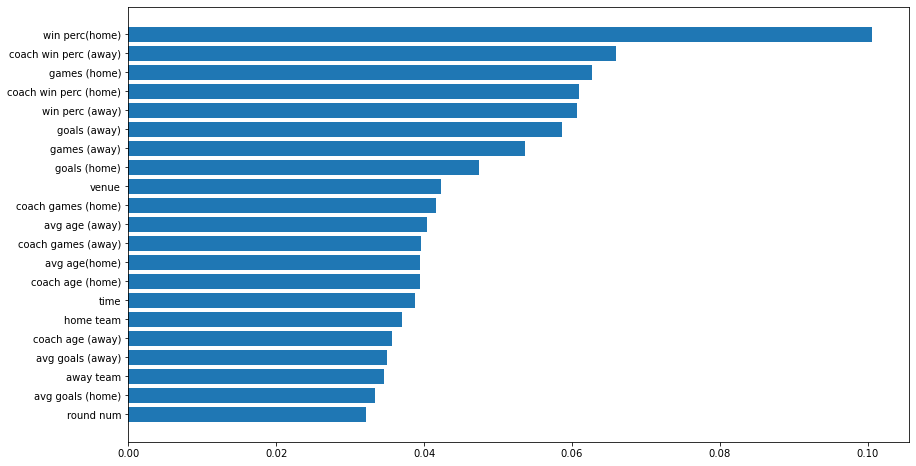

In [45]:
feature_labels = np.array(feature_labels)

importance = np.array(xgb_hyperopt.feature_importances_)
imp_sort = np.argsort(importance)
F = plt.figure(figsize=(14,8))
ax = F.add_subplot(111)
ax.barh(range(len(importance)),importance[imp_sort],tick_label=feature_labels[imp_sort])
plt.show()

So it seems that the best predictors of whether or not the home team wins are the win percentages of the coaches and teams, which is not particularly surprising. After that, we find features like total games and total goals, which likely are representative of the experience of each team. It seems as well that the actual teams, venue, and game time don't really matter too much.

The raw feature importance provided by XGBoost is fairly general, however and doesn't provide a deep insight into the decision making process. To get a deeper understanding, we can use SHapley Additive exPlanation (SHAP) values using the shap package:

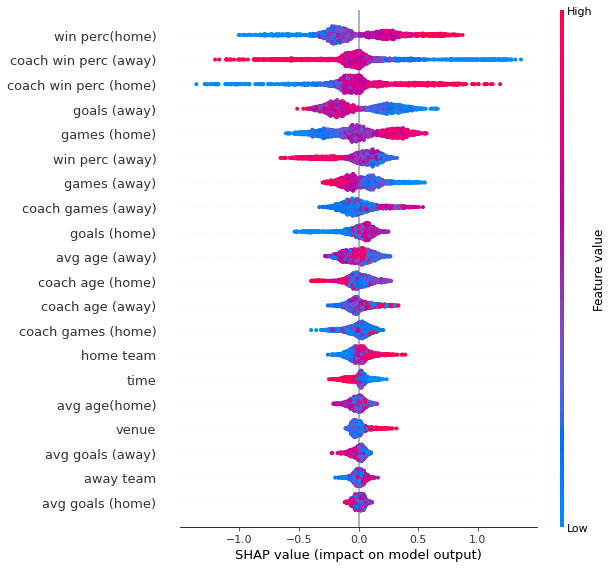

In [46]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_hyperopt)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_labels)

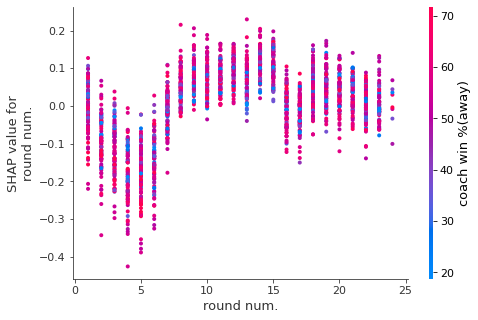

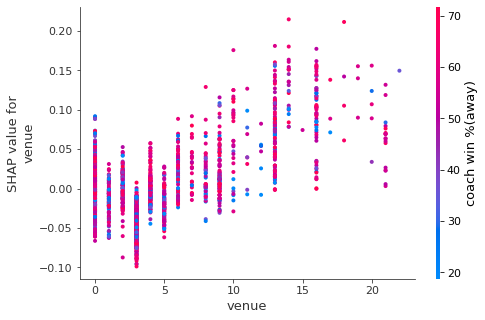

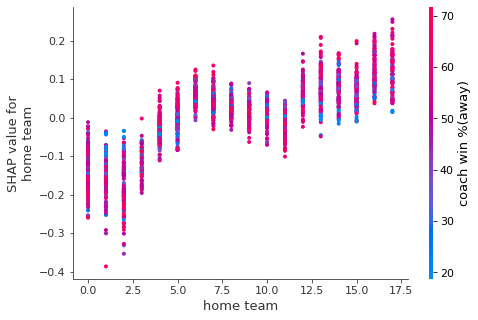

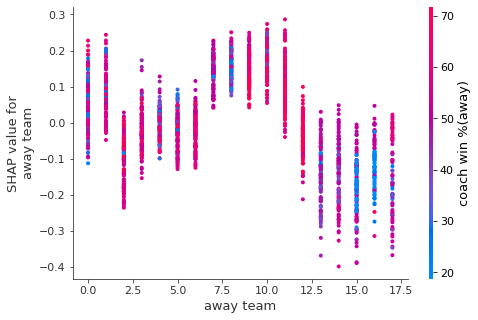

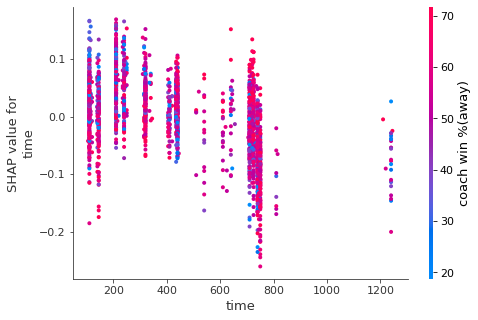

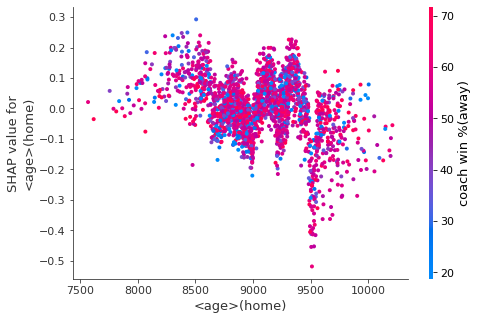

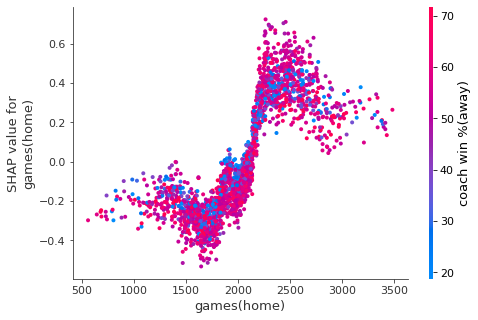

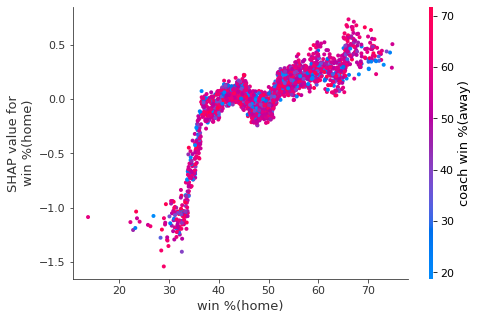

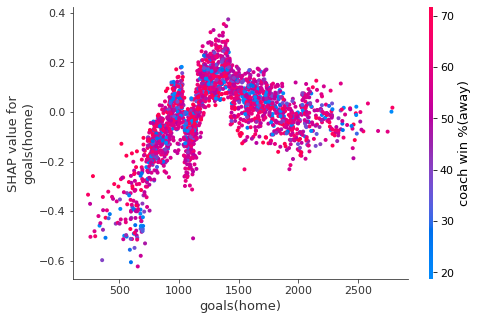

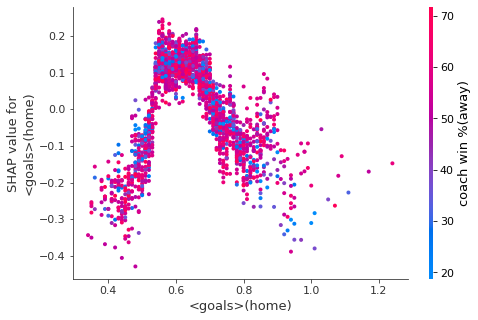

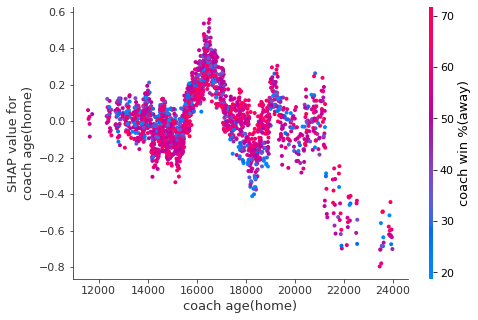

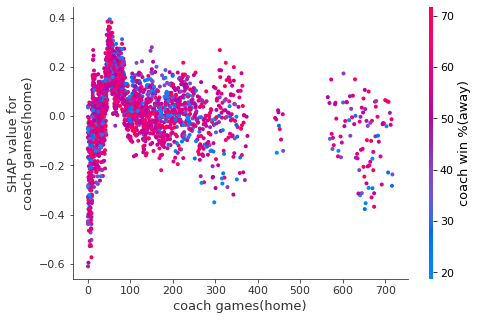

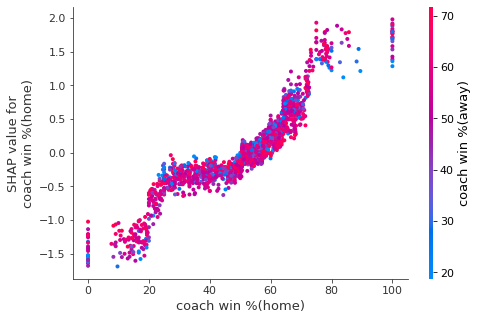

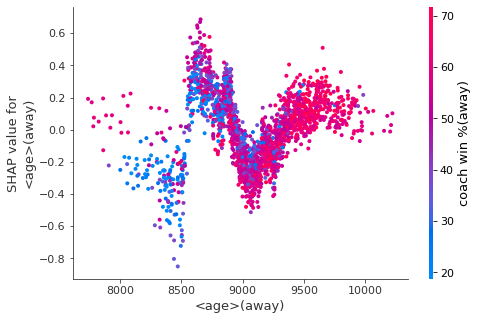

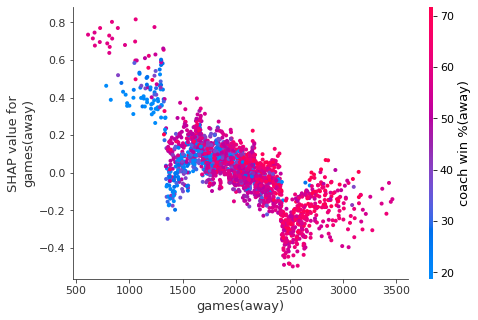

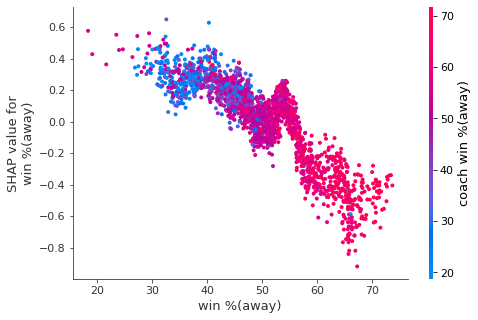

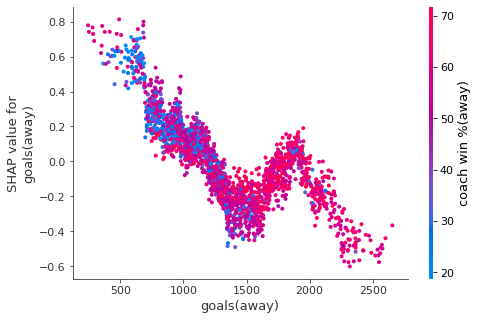

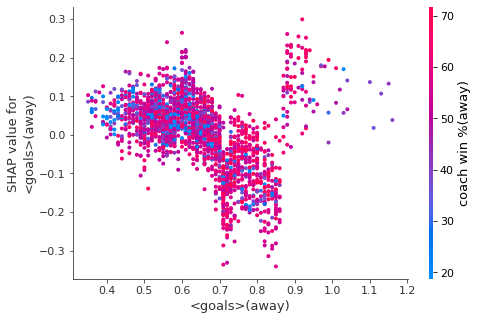

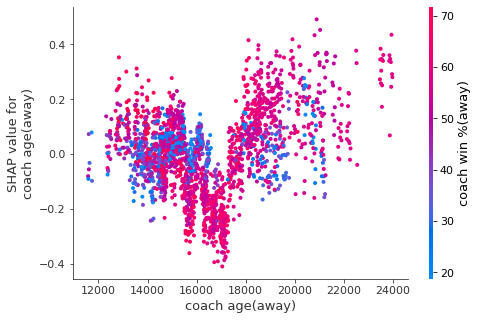

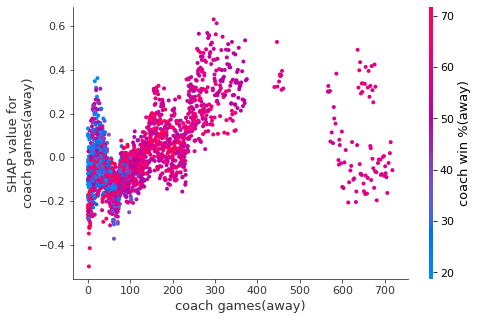

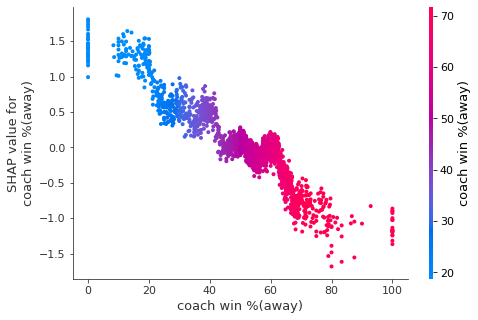

In [61]:
for i in range(len(feature_labels)):
    shap.dependence_plot(i, shap_values, X, feature_labels,interaction_index=-1)#, display_features=feature_labels)

### Other ML Models

In many cases model training and selection really is as easy as this. Of course, there is a lot of stuff going on under the hood with these algorithms and certain algorithms may perform better from one case to another. A detailed discussion of the pros and cons of each model in the context of different types of problems is beyond the scope of this talk, so I leave it to you to explore further if inteterested. Regardless, there are a number of algorithms for classifying tabular data and they are remarkably easy to implement with sklearn.

To illustrate how easy it is to employ other types of models here are a few examples in sklearn:

In [50]:
# K-NEAREST NEIGHBORS (KNN)
from sklearn.neighbors import KNeighborsClassifier

KNNmod = KNeighborsClassifier().fit(X_train,y_train)




# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.preprocessing import StandardScaler

# Some models work best when training data is scaled to a similar order of magnitude*
scaler = StandardScaler()
scaler.fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test1)
Xt2 = scaler.transform(X_test2)

lrmod = LogReg(max_iter=10000).fit(Xtr,y_train)




# SUPPORT VECTOR MACHINE (SVM)
from sklearn.svm import SVC

svmod = SVC().fit(Xtr,y_train)




# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB

NBmod = GaussianNB().fit(Xtr,y_train)




# NEUARL NETWORK (slightly more complicated...)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

NNmod = Sequential()
NNmod.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
NNmod.add(Dropout(0.2))
NNmod.add(Dense(1, activation='sigmoid'))

NNmod.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
)

history = NNmod.fit(X_train,y_train,
                    batch_size=75,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test1,y_test1)
)




print(' Results for all our new models:')
print('---------------------------------------------------------------')
pred1  = xgb_hyperopt.predict(X_test1)
print(f'XGBoost 2018 accuracy = {acc(y_test1,pred1)}')
pred2  = xgb_hyperopt.predict(X_test2)
print(f'XGBoost 2019 accuracy = {acc(y_test2,pred2)}')
print('---------------------------------------------------------------')
print(f'KNN 2018 accuracy = {acc(y_test1,KNNmod.predict(X_test1))}')
print(f'KNN 2019 accuracy = {acc(y_test2,KNNmod.predict(X_test2))}')
print('---------------------------------------------------------------')
print(f'Logistic Regression 2018 accuracy = {acc(y_test1,lrmod.predict(Xte))}')
print(f'Logistic Regression 2019 accuracy = {acc(y_test2,lrmod.predict(Xt2))}')
print('---------------------------------------------------------------')
print(f'SVM 2018 accuracy = {acc(y_test1,svmod.predict(Xte))}')
print(f'SVM 2019 accuracy = {acc(y_test2,svmod.predict(Xt2))}')
print('---------------------------------------------------------------')
print(f'Naive Bayes 2018 accuracy = {acc(y_test1,NBmod.predict(Xte))}')
print(f'Naive Bayes 2019 accuracy = {acc(y_test2,NBmod.predict(Xt2))}')
print('---------------------------------------------------------------')
score = NNmod.evaluate(X_test1,y_test1,verbose=0)
print(f'Neural Net 2018 Accuracy = {score[1]}')
score = NNmod.evaluate(X_test2,y_test2,verbose=0)
print(f'Neural Net 2019 Accuracy = {score[1]}')

 Results for all our new models:
---------------------------------------------------------------
XGBoost 2018 accuracy = 0.7252557544757032
XGBoost 2019 accuracy = 0.6192156862745098
---------------------------------------------------------------
KNN 2018 accuracy = 0.6460358056265985
KNN 2019 accuracy = 0.6209803921568628
---------------------------------------------------------------
Logistic Regression 2018 accuracy = 0.7356777493606138
Logistic Regression 2019 accuracy = 0.6258823529411766
---------------------------------------------------------------
SVM 2018 accuracy = 0.7058184143222507
SVM 2019 accuracy = 0.5858823529411765
---------------------------------------------------------------
Naive Bayes 2018 accuracy = 0.7274936061381074
Naive Bayes 2019 accuracy = 0.6150980392156863
---------------------------------------------------------------
Neural Net 2018 Accuracy = 0.6836158037185669
Neural Net 2019 Accuracy = 0.6214689016342163


So it turns out that after all the trouble we went through to tune our XGBoost model to get the best hyperparameters, I simple, untuned logistic regression or naive bayes model does slightly better... go figure. It's possible that by identifying new features or by engineering new ones from those already available, we could improve the accuracy of our model and get better predictions. I spent a while trying to do this, but never got any significant improvement. 

### How'd we do?

So in the end we were able to predict AFL matches in 2018 and 2019 with ~73% and ~63% accuracy. There is actually a fair bit of literature in the field of AI sports outcome prediction, and it turns out that these accuracies are in the ballpark for the best performing models across a range of sports. It's likely that no matter what we do, we simply won't do much better than this. This likely just reflects the fact that there is a fair bit of chance when it comes to sport... which is a good thing as it would be pretty boring if we always knew who was going to win from the start!